In [2]:
import torch
from transformers import DebertaV2Model, DebertaV2Tokenizer
MODEL_NAME = 'microsoft/deberta-v3-small'
model = DebertaV2Model.from_pretrained(MODEL_NAME)
tokenizer = DebertaV2Tokenizer.from_pretrained(MODEL_NAME)


/rhome/eingerman/mambaforge/envs/vits2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
texts=["Hellow World", "Good nights", "What is going on?"]
encoded_input = tokenizer(texts, return_tensors='pt', padding=True)

output = model(**encoded_input, output_hidden_states=True)
bart_out = torch.cat(output["hidden_states"][-3:-2], -1)[0]
converted=tokenizer.convert_ids_to_tokens(encoded_input["input_ids"][1])


In [29]:
output["hidden_states"][-3:-2].shape

AttributeError: 'tuple' object has no attribute 'shape'

In [19]:
output["hidden_states"][-3:-2][0].shape

torch.Size([3, 7, 768])

In [21]:
encoded_input["input_ids"].shape

torch.Size([3, 7])

In [11]:
converted=tokenizer.convert_ids_to_tokens(encoded_input["input_ids"])

ValueError: only one element tensors can be converted to Python scalars

In [9]:
text = "when these rays reach the observer direct, he sees the lamps or luminiferous bodies themselves, but when he is out of their direct sight, the brightness of their illumination only becomes apparent, through the rays being collected and reflected by some appropriate substance."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input, output_hidden_states=True)
res = torch.cat(output["hidden_states"][-3:-2], -1)[0].cpu()

tk=tokenizer.tokenize(text)
print(encoded_input["input_ids"].shape, output.last_hidden_state.shape, len(tk))

torch.Size([1, 51]) torch.Size([1, 51, 768]) 49


In [10]:
converted=tokenizer.convert_ids_to_tokens(encoded_input["input_ids"][0])
print(converted)

['[CLS]', '▁when', '▁these', '▁rays', '▁reach', '▁the', '▁observer', '▁direct', ',', '▁he', '▁sees', '▁the', '▁lamps', '▁or', '▁lumin', 'iferous', '▁bodies', '▁themselves', ',', '▁but', '▁when', '▁he', '▁is', '▁out', '▁of', '▁their', '▁direct', '▁sight', ',', '▁the', '▁brightness', '▁of', '▁their', '▁illumination', '▁only', '▁becomes', '▁apparent', ',', '▁through', '▁the', '▁rays', '▁being', '▁collected', '▁and', '▁reflected', '▁by', '▁some', '▁appropriate', '▁substance', '.', '[SEP]']


In [11]:
#Test for mapping from tokenizer output back to original text

path="filelists/libritts_audio_sid_grapheme_all_filelist.txt.cleaned"
for l in open(path, 'r'):
    text = l.split('|')[2]
    encoded_input = tokenizer(text.strip(), return_tensors='pt')
    converted=tokenizer.convert_ids_to_tokens(encoded_input["input_ids"][0])

    tokens_nospecials = [c for c in converted if not(c in tokenizer.all_special_tokens)]
    remove_whitespace = lambda c: (" " + c[1:]) if c[0] == "▁" else c
    token_list = map(remove_whitespace, tokens_nospecials)
    tokenized_str = ("".join(token_list)).strip()
    if not (text.strip() == tokenized_str ):
        print(f"{text.strip()}\n{tokenized_str}")
        


In [16]:
import torch

def repeat_columns(tensor, repeats):
    # Ensure the tensor and repeats list are on the same device
    tensor = tensor.to(repeats.device)

    # Repeat the columns of the tensor
    repeated_tensor = torch.repeat_interleave(tensor, repeats, dim=1)

    return repeated_tensor

# Original tensor
tensor = torch.tensor([[1, 2, 3], [4, 5, 6]])

# List of repeats
repeats = torch.tensor([2, 0, 3])

# Call the function
repeated_tensor = repeat_columns(tensor, repeats)

# Print the repeated tensor
print(repeated_tensor)



tensor([[1, 1, 3, 3, 3],
        [4, 4, 6, 6, 6]])


In [51]:
def tokenize_bart_enc(text):
    encoded_input = tokenizer(text.strip(), return_tensors='pt')
    output = model(**encoded_input, output_hidden_states=True)
    bart_out = torch.cat(output["hidden_states"][-3:-2], -1)[0]

    converted=tokenizer.convert_ids_to_tokens(encoded_input["input_ids"][0])

    remove_whitespace = lambda c: (" " + c[1:]) if ((len(c)>0) and c[0] == "▁") else c

    tokens_nospecials = [ (c if not(c in tokenizer.all_special_tokens) else "") for c in converted ]

    token_list = list(map(remove_whitespace, tokens_nospecials))
    if len(token_list[0])==0:
        token_list[1] = token_list[1].strip()
    repl_list = [len(token) for token in token_list]
    
    repeats = torch.tensor(repl_list, device=bart_out.device)
    print(f"{bart_out.shape=}")
    print(f"{repeats.shape=}")
    repeated_tensor = torch.repeat_interleave(bart_out, repeats, dim=0)
    # assert repeated_tensor.shape[0] == sum(repl_list)
    print(f"{repeated_tensor.shape=}, {sum(repl_list)=}")
    return (repeated_tensor, repl_list) #, token_list)

In [52]:
text=["at night we camp at a water pocket, a pool in a great limestone rock.", "at night we come to the cliff, and under it, in a great cave, we find a lakelet."]
print(tokenize_bart_enc(text[0]))
print(tokenize_bart_enc(text[1]))



bart_out.shape=torch.Size([19, 768])
repeats.shape=torch.Size([19])
repeated_tensor.shape=torch.Size([69, 768]), sum(repl_list)=69
(tensor([[ 1.8150e-01, -5.4775e-01,  9.9657e-02,  ..., -6.1669e-01,
          4.0106e-01,  1.0836e-01],
        [ 1.8150e-01, -5.4775e-01,  9.9657e-02,  ..., -6.1669e-01,
          4.0106e-01,  1.0836e-01],
        [ 8.5165e-02, -9.8955e-01, -4.2447e-01,  ..., -9.3168e-01,
          4.4037e-01,  2.4962e-01],
        ...,
        [-1.7115e+00,  2.4747e-02,  6.2423e-02,  ..., -1.5398e-01,
          2.5467e-01,  8.1702e-01],
        [-1.7115e+00,  2.4747e-02,  6.2423e-02,  ..., -1.5398e-01,
          2.5467e-01,  8.1702e-01],
        [-2.1153e-01, -1.8108e-01, -1.4590e-02,  ..., -2.3116e-02,
         -7.8113e-04, -7.0608e-02]], grad_fn=<IndexSelectBackward0>), [0, 2, 6, 3, 5, 3, 2, 6, 7, 1, 2, 5, 3, 2, 6, 10, 5, 1, 0])
bart_out.shape=torch.Size([25, 768])
repeats.shape=torch.Size([25])
repeated_tensor.shape=torch.Size([80, 768]), sum(repl_list)=80
(tensor([[-0

In [27]:
encoded_input

{'input_ids': tensor([[    1,   313,   364,  1331,   262, 54213,   842,   261,  1661,  1365,
           281,  1707,   263, 22644,   261,  4850,   314,   347, 12668,   576,
           619,   293,   266,   426,   263,  9410,  3920,   267, 13753,   277,
           266,  3759,   260,     2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [29]:
tokenizer.decode(encoded_input['input_ids'][0])

'[CLS] he only heard the heathen men, whose eyes are blue and bleak, singing about some cruel thing done by a great and smiling king in daylight on a deck.[SEP]'

In [17]:
import difflib

str=""
for c in converted:
    if not(c in tokenizer.all_special_tokens):
        if c[0] == "▁":
            c = " "+c[1:]
        str=str+c

print(text==str.strip())
print("".join(difflib.ndiff(str.strip(), text)), end="")


True
  w  h  e  n     t  h  e  s  e     r  a  y  s     r  e  a  c  h     t  h  e     o  b  s  e  r  v  e  r     d  i  r  e  c  t  ,     h  e     s  e  e  s     t  h  e     l  a  m  p  s     o  r     l  u  m  i  n  i  f  e  r  o  u  s     b  o  d  i  e  s     t  h  e  m  s  e  l  v  e  s  ,     b  u  t     w  h  e  n     h  e     i  s     o  u  t     o  f     t  h  e  i  r     d  i  r  e  c  t     s  i  g  h  t  ,     t  h  e     b  r  i  g  h  t  n  e  s  s     o  f     t  h  e  i  r     i  l  l  u  m  i  n  a  t  i  o  n     o  n  l  y     b  e  c  o  m  e  s     a  p  p  a  r  e  n  t  ,     t  h  r  o  u  g  h     t  h  e     r  a  y  s     b  e  i  n  g     c  o  l  l  e  c  t  e  d     a  n  d     r  e  f  l  e  c  t  e  d     b  y     s  o  m  e     a  p  p  r  o  p  r  i  a  t  e     s  u  b  s  t  a  n  c  e  .

In [15]:
print(text)
print(str)

when these rays reach the observer direct, he sees the lamps or luminiferous bodies themselves, but when he is out of their direct sight, the brightness of their illumination only becomes apparent, through the rays being collected and reflected by some appropriate substance.
 when these rays reach the observer direct, he sees the lamps or luminiferous bodies themselves, but when he is out of their direct sight, the brightness of their illumination only becomes apparent, through the rays being collected and reflected by some appropriate substance.


In [14]:
print(output.last_hidden_state.shape, len(tk))

torch.Size([1, 51, 768]) 49


In [5]:
encoded_input

{'input_ids': tensor([[    1,   335,   378, 12346,  1431,   262, 17450,  1670,   261,   313,
          5649,   262, 10605,   289, 77697, 65372,  3362,  1147,   261,   304,
           335,   313,   269,   321,   265,   308,  1670,  3941,   261,   262,
         14436,   265,   308, 19956,   364,  2159,  5557,   261,   390,   262,
         12346,   411,  3422,   263,  7034,   293,   347,  1825,  5182,   260,
             2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]])}

In [70]:
transformers.__version__

NameError: name 'transformers' is not defined

In [7]:
tk=tokenizer.tokenize(text)
print(tk)

['▁when', '▁these', '▁rays', '▁reach', '▁the', '▁observer', '▁direct', ',', '▁he', '▁sees', '▁the', '▁lamps', '▁or', '▁lumin', 'iferous', '▁bodies', '▁themselves', ',', '▁but', '▁when', '▁he', '▁is', '▁out', '▁of', '▁their', '▁direct', '▁sight', ',', '▁the', '▁brightness', '▁of', '▁their', '▁illumination', '▁only', '▁becomes', '▁apparent', ',', '▁through', '▁the', '▁rays', '▁being', '▁collected', '▁and', '▁reflected', '▁by', '▁some', '▁appropriate', '▁substance', '.']


In [69]:
for w in encoded_input.word_ids():
    print(w)

ValueError: word_ids() is not available when using non-fast tokenizers (e.g. instance of a `XxxTokenizerFast` class).

In [57]:
output1=torch.cat(output["hidden_states"][-3:-2], -1)[0]
output1.shape[0]

12

AttributeError: 'torch.Size' object has no attribute 'shape'

In [37]:
encoded_input[0]

KeyError: 'Invalid key. Only three types of key are available: (1) string, (2) integers for backend Encoding, and (3) slices for data subsetting.'

In [35]:
b=torch.cat(output["hidden_states"][-3:-2], -1)


tensor([[[ 4.7815e-02, -6.4330e-02, -9.3293e-02,  ...,  1.8593e-02,
           2.0229e-02,  4.8493e-02],
         [-1.0126e+00, -5.7708e-01,  2.5398e-01,  ...,  8.8124e-01,
           4.5454e-01, -2.3135e-01],
         [-2.3604e-01,  5.8270e-01, -1.4709e-01,  ...,  9.6723e-01,
           4.0348e-01, -2.1966e-01],
         ...,
         [ 4.9370e-01, -4.5198e-02,  2.3887e-01,  ...,  8.6032e-01,
           5.7410e-01, -6.6281e-04],
         [-9.7019e-02, -2.0085e-01, -1.0030e-01,  ...,  2.6730e-01,
          -5.6538e-03,  2.1169e-03],
         [ 6.7819e-02, -4.0412e-02, -6.2213e-02,  ...,  1.7648e-02,
          -2.8052e-03,  1.1247e-02]]], grad_fn=<CatBackward0>)

In [30]:
(output['hidden_states'][-3:-2])[0].shape

torch.Size([1, 12, 768])

34

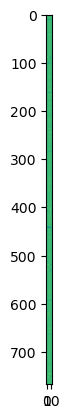

In [16]:
import pylab as pl
pl.imshow(output.last_hidden_state.detach().numpy()[0,:,:].T)
encoded_input.input_ids.shape
len(text)

In [11]:
output.last_hidden_state

tensor([[[-0.0082,  0.0093, -0.0317,  ..., -0.0706, -0.0346, -0.0810],
         [-1.0421, -0.2735,  0.1558,  ...,  0.4248,  0.5864,  0.4635],
         [ 0.4201, -0.1396, -0.2986,  ...,  0.2817, -0.2221, -0.1911],
         ...,
         [ 0.8387, -0.2888,  0.7874,  ...,  0.2854,  0.4556,  0.4273],
         [-0.2095,  0.1081,  0.3647,  ...,  0.3607,  0.0144, -0.0899],
         [ 0.0027,  0.0066, -0.0280,  ..., -0.0765, -0.0286, -0.0639]]],
       grad_fn=<NativeLayerNormBackward0>)

In [3]:
texts=["Hellow World", "Good nights", "What is going on?"]
encoded_input = tokenizer(texts, return_tensors='pt', padding=True)

output = model(**encoded_input, output_hidden_states=True)
bart_out = torch.cat(output["hidden_states"][-3:-2], -1)[0]
converted=tokenizer.convert_ids_to_tokens(encoded_input["input_ids"][1])


In [4]:
def tokenize_bert_enc(texts):
    encoded_input = tokenizer(texts, return_tensors='pt', padding=True)
    output = model(**encoded_input, output_hidden_states=True)
    bart_out = torch.cat(output["hidden_states"][-3:-2], -1)[0]

    remove_whitespace = lambda c: (" " + c[1:]) if ((len(c)>0) and c[0] == "▁") else c
    all_tensors = []
    for encoded in encoded_input["input_ids"]:
        converted=tokenizer.convert_ids_to_tokens(encoded)
        tokens_nospecials = [ (c if not(c in tokenizer.all_special_tokens) else "") for c in converted ]

        token_list = list(map(remove_whitespace, tokens_nospecials))
        if len(token_list[0])==0:
            token_list[1] = token_list[1].strip()
        repl_list = [len(token) for token in token_list]
    
        repeats = torch.tensor(repl_list, device=bart_out.device)
        # print(f"{bart_out.shape=}")
        # print(f"{repeats.shape=}")
        repeated_tensor = torch.repeat_interleave(bart_out, repeats, dim=0)
        # assert repeated_tensor.shape[0] == sum(repl_list), f"{text}: {bart_out.shape=}, {repeated_tensor.shape=}, {sum(repl_list)=}"
        # print(f"{repeated_tensor.shape=}, {sum(repl_list)=}")
        all_tensors.append(repeated_tensor)

    max_rows = max(tensor.size(0) for tensor in all_tensors)
    padded_tensors = [torch.nn.functional.pad(tensor, (0, 0, 0, max_rows - tensor.size(0))) for tensor in all_tensors]
    stacked_tensors = torch.stack(padded_tensors, dim=0)

    return stacked_tensors

stacked_tensors=tokenize_bert_enc(texts)
stacked_tensors.shape

torch.Size([3, 17, 768])

In [38]:
encoded_input["input_ids"].shape

torch.Size([3, 7])

In [39]:
[len(t) for t in texts]

[12, 11, 17]

In [35]:
r.shape

torch.Size([17, 768])

In [1]:
from text import cleaned_text_to_sequence, sequence_to_text

txt = "Hello"

sequence = cleaned_text_to_sequence(txt)
print(sequence)
print(sequence_to_text(sequence))

[24, 47, 54, 54, 57]
Hello
